<a href="https://colab.research.google.com/github/MS-H2020/Open/blob/main/dnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [活動センサーログからの動作予測](https://signate.jp/competitions/116/submissions)

Thanks to "KASHISHBHAGAT" for my reference [Human Activity Recognition Using Neural Networks](https://www.kaggle.com/code/kashish8610/human-activity-recognition-using-neural-networks)

## Google Colabの設定

In [32]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [33]:
#TEMP_DIR = "./temp"
INPUT_DIR:str = "/content/drive/MyDrive/Human_Activity_Recognition_with_Smartphones/01_input"
#TRAIN_DIR:str = INPUT_DIR + "/train_data"
#TEST_DIR:str = INPUT_DIR + "/test_data"
ANALYSIS_DIR:str = "/content/drive/MyDrive/Human_Activity_Recognition_with_Smartphones/03_code-analysis"
MODEL_DIR:str = "/content/drive/MyDrive/Human_Activity_Recognition_with_Smartphones//04_model"
SUBMISSION_DIR:str = '/content/drive/MyDrive/Human_Activity_Recognition_with_Smartphones/05_submission'
CHECKPOINT_PATH:str = MODEL_DIR

## メインコード

In [34]:
import tensorflow as tf
from tensorflow import keras

import os
import tempfile

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [35]:
df = pd.read_csv(INPUT_DIR+"/train.tsv", index_col='id', sep='\t')

In [36]:
df

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",activity
id,,,,,,,,,,,,,,,,,,,,,
0,0.273049,0.029455,-0.108114,0.169687,-0.010238,-0.328502,0.124848,-0.107618,-0.276389,0.445229,...,-0.548450,-0.889451,0.163217,-0.924336,-0.979567,0.679692,-0.767623,0.241396,-0.056989,WALKING_DOWNSTAIRS
2,0.252055,-0.035983,-0.128469,-0.436843,-0.153635,-0.223741,-0.450711,-0.169382,-0.214256,-0.482311,...,-0.086837,-0.383948,0.161606,-0.047325,0.059193,-0.135756,-0.816405,0.172032,0.125650,WALKING
3,0.283767,-0.016931,-0.109087,-0.988980,-0.989567,-0.986512,-0.989212,-0.988799,-0.986351,-0.931380,...,-0.445331,-0.845203,-0.014492,0.756477,-0.762958,-0.958952,0.599734,-0.854922,-0.138131,LAYING
4,0.259078,-0.016357,-0.114833,-0.993216,-0.992404,-0.989001,-0.993880,-0.991913,-0.988457,-0.942268,...,0.624687,0.498270,0.087316,-0.434805,-0.478510,0.530472,0.677465,-0.581916,-0.416544,LAYING
5,0.273949,-0.021795,-0.117436,-0.995829,-0.984692,-0.986809,-0.996566,-0.984201,-0.986983,-0.933887,...,-0.393550,-0.757986,-0.007627,0.051640,0.665034,0.697867,-0.679295,0.319584,0.025221,STANDING
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10288,0.264015,0.038842,-0.120877,-0.232794,-0.235580,-0.459693,-0.351933,-0.241603,-0.463831,-0.031382,...,-0.160632,-0.588660,0.211543,-0.781484,0.766219,0.468048,-0.771033,0.256378,0.017798,WALKING_UPSTAIRS
10289,0.279222,-0.005795,-0.092436,-0.996173,-0.969167,-0.980864,-0.996487,-0.969335,-0.978718,-0.939277,...,0.080477,-0.185231,0.010776,-0.255061,0.253623,0.376215,-0.796369,0.213405,-0.065949,STANDING
10292,0.272877,-0.033118,-0.086875,-0.416898,-0.080907,-0.369057,-0.466169,-0.104662,-0.358857,-0.081558,...,0.755409,0.663630,0.006660,-0.119243,-0.176671,-0.007256,-0.729335,0.257128,0.118934,WALKING


In [37]:
# Use a utility from sklearn to split and shuffle your dataset.
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['activity'])

In [38]:
X_train=train_df.iloc[:,:-1]
y_train=train_df.iloc[:,-1]

X_test=test_df.iloc[:,:-1]
y_test=test_df.iloc[:,-1]

In [39]:
from sklearn.preprocessing import StandardScaler
sc=StandardScaler()
X_train=sc.fit_transform(X_train)
X_test=sc.transform(X_test)

In [40]:
from sklearn.preprocessing import LabelEncoder
encoder=LabelEncoder()
y_train=encoder.fit_transform(y_train)
y_train=pd.get_dummies(y_train).values

In [41]:
from sklearn.preprocessing import LabelEncoder
encoder=LabelEncoder()
y_test=encoder.fit_transform(y_test)
y_test=pd.get_dummies(y_test).values

In [42]:
pip install keras-tuner

In [43]:
import keras_tuner
from keras.models import Sequential
from keras.layers import Dense,Dropout

In [44]:
def build_model(hp):
  model=Sequential()
  model.add(Dense(units=64,kernel_initializer='uniform',activation='relu',input_dim=X_train.shape[1]))
  model.add(Dense(units=128,kernel_initializer='uniform',activation='relu'))
  model.add(Dense(units=64,kernel_initializer='uniform',activation='relu'))
  model.add(Dense(units=6,kernel_initializer='uniform',activation='softmax'))
  model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
  return model

In [45]:
tuner = keras_tuner.RandomSearch(
      build_model,
      objective='val_accuracy',
      max_trials=5,
      directory='my_dir',
      project_name='kerastune'
  )

In [46]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [47]:
tuner.search(X_train,y_train,batch_size=256,epochs=22,validation_data=(X_test,y_test), callback=[stop_early])
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
model = tuner.hypermodel.build(best_hps)

Trial 1 Complete [00h 00m 01s]

Best val_accuracy So Far: None
Total elapsed time: 00h 00m 01s


In [48]:
history=model.fit(X_train,y_train,batch_size=256,epochs=22,validation_data=(X_test,y_test))

Epoch 1/22
17/17 [==============================] - 2s 23ms/step - loss: 1.5529 - accuracy: 0.3353 - val_loss: 1.1208 - val_accuracy: 0.3301
Epoch 2/22
17/17 [==============================] - 0s 8ms/step - loss: 1.0324 - accuracy: 0.4715 - val_loss: 0.8879 - val_accuracy: 0.6660
Epoch 3/22
17/17 [==============================] - 0s 8ms/step - loss: 0.7340 - accuracy: 0.7242 - val_loss: 0.5651 - val_accuracy: 0.7845
Epoch 4/22
17/17 [==============================] - 0s 8ms/step - loss: 0.4815 - accuracy: 0.8247 - val_loss: 0.3899 - val_accuracy: 0.8427
Epoch 5/22
17/17 [==============================] - 0s 8ms/step - loss: 0.3409 - accuracy: 0.8657 - val_loss: 0.3011 - val_accuracy: 0.8893
Epoch 6/22
17/17 [==============================] - 0s 7ms/step - loss: 0.2438 - accuracy: 0.9068 - val_loss: 0.2064 - val_accuracy: 0.9214
Epoch 7/22
17/17 [==============================] - 0s 8ms/step - loss: 0.1763 - accuracy: 0.9328 - val_loss: 0.1629 - val_accuracy: 0.9369
Epoch 8/22
17/17 [=

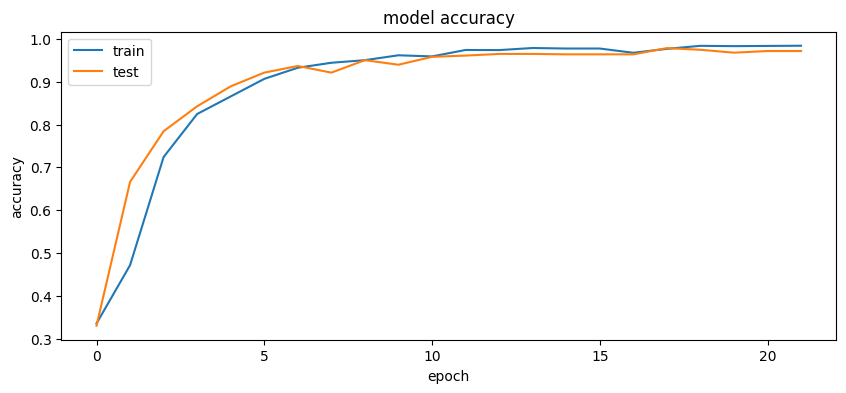

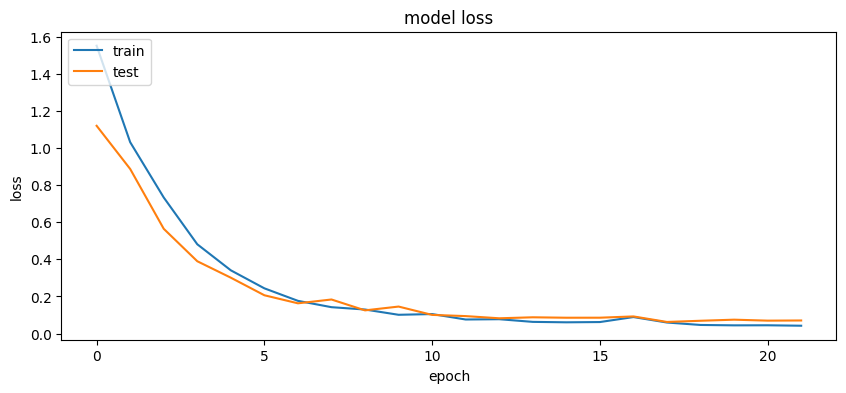

In [49]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 4
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [50]:
y_pred=model.predict(X_test)

33/33 [==============================] - 0s 3ms/step


In [51]:
y_test_class=np.argmax(y_test,axis=1)
y_pred_class=np.argmax(y_pred,axis=1)

In [52]:
y_test_class

array([5, 1, 1, ..., 4, 3, 2])

In [53]:
y_pred_class

array([5, 1, 1, ..., 4, 3, 2])

In [54]:
from sklearn.metrics import confusion_matrix,accuracy_score
cm=confusion_matrix(y_test_class,y_pred_class)
accuracy=accuracy_score(y_test_class,y_pred_class)

In [55]:
cm

array([[203,   0,   0,   0,   0,   0],
       [  0, 157,  22,   0,   0,   0],
       [  0,   4, 181,   0,   0,   0],
       [  0,   0,   0, 171,   0,   0],
       [  0,   0,   0,   0, 136,   0],
       [  0,   0,   0,   3,   0, 153]])

In [56]:
accuracy

0.9718446601941747

### submitファイルの作成

In [57]:
submit_df = pd.read_csv(INPUT_DIR+"/test.tsv", index_col=0, sep='\t')

In [58]:
scaler = StandardScaler()
submit_df_scaled = scaler.fit_transform(submit_df)
pd.DataFrame(submit_df_scaled).head()

,0,1,2,3,4,5,6,7,8,9,...,551,552,553,554,555,556,557,558,559,560
0,-0.874625,-0.333227,0.883818,1.325547,1.453147,1.867636,1.337906,1.556096,1.686591,1.642692,...,-0.119036,0.854603,0.597031,1.332338,-0.972043,0.913501,-1.823668,-0.503695,0.498432,0.672969
1,0.064603,0.000577,-0.065833,-0.888530,-0.960076,-0.943453,-0.883547,-0.959895,-0.953316,-0.866465,...,1.842171,-1.722300,-1.102230,0.385025,-0.165068,0.167247,-0.744292,-0.371861,-0.361628,-0.382035
2,-0.045344,-0.033432,0.062777,-0.885219,-0.976391,-0.938056,-0.880247,-0.976892,-0.945776,-0.876110,...,1.878801,-0.961731,-0.769497,0.079145,0.246805,-0.424987,1.070697,2.035545,-2.081482,-1.503133
3,-1.376807,0.015636,0.067328,1.166911,0.832146,1.166560,1.099745,0.845422,1.237343,1.508028,...,-0.292170,0.290688,0.082421,2.195873,-0.392965,-0.986887,-0.177782,-0.035377,0.504046,1.419515
4,0.040864,0.155495,0.029448,-0.895779,-0.977223,-0.914862,-0.889261,-0.976177,-0.913867,-0.889332,...,1.812790,-1.587776,-1.127148,0.453699,0.147924,0.085530,-0.520712,-0.666842,0.447230,0.257977


In [59]:
type(submit_df_scaled)

numpy.ndarray

In [60]:
pred = model.predict(submit_df_scaled)
pred_label = np.argmax(pred,axis=1)
pred_class = list(encoder.inverse_transform(pred_label))

161/161 [==============================] - 0s 2ms/step


In [61]:
ans = pd.read_csv(INPUT_DIR+"/sample_submit.csv",  header=None)
ans[1] = pred_class
ans.to_csv(path_or_buf = SUBMISSION_DIR+"/submit.csv", index=False, header=None)

In [62]:
ans

,0,1
0,1,WALKING
1,6,SITTING
2,8,LAYING
3,9,WALKING_UPSTAIRS
4,12,STANDING
...,...,...
5145,10291,SITTING
5146,10293,STANDING
5147,10295,WALKING_DOWNSTAIRS
5148,10297,STANDING
